In [1]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset, read_pred_csv
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

from torch import Tensor
from collections import OrderedDict, defaultdict


import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
DEBUG = False

# training cfg
validation_cfg = {
    
    'format_version': 4,
    
     ## Model options
    'model_params': {
        'model_architecture': 'resnet34',
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
    },

    ## Input raster parameters
    'raster_params': {
        
        'raster_size': [224, 224], # raster's spatial resolution [meters per pixel]: the size in the real world one pixel corresponds to.
        'pixel_size': [0.5, 0.5], # From 0 to 1 per axis, [0.5,0.5] would show the ego centered in the image.
        'ego_center': [0.25, 0.5],
        'map_type': "py_semantic",
        
        # the keys are relative to the dataset environment variable
        'satellite_map_key': "aerial_map/aerial_map.png",
        'semantic_map_key': "semantic_map/semantic_map.pb",
        'dataset_meta_key': "meta.json",

        # e.g. 0.0 include every obstacle, 0.5 show those obstacles with >0.5 probability of being
        # one of the classes we care about (cars, bikes, peds, etc.), >=1.0 filter all other agents.
        'filter_agents_threshold': 0.5
    },

    ## Data loader options
    'valid_data_loader': {
        'key': "scenes/validate_chopped_100/validate.zarr",
        'batch_size': 1,
        'shuffle': False,
        'num_workers': 0
    },

    ## Valid params
    'valid_params': {
        'checkpoint_every_n_steps': 5000,
        'max_num_steps': 10 if DEBUG else 1000
    }
}

common_cfg = {
    'seed': 500,
    'output_dir': './outputs/1011_2/',
    'epoch': 2,
    'train_step': 5 if DEBUG else 500,
    'valid_step': 5 if DEBUG else 50,
    'train_max': 12,
    'learning_rate': 1e-3
}


In [3]:
OUTPUT_DIR = common_cfg['output_dir']
INPUT_ROOT = Path('/home/knikaido/work/Lyft/data/')
DATA_DIR = INPUT_ROOT / 'lyft-motion-prediction-autonomous-vehicles/'

In [4]:
pred_path = f"{OUTPUT_DIR}/pred_1010.csv"

In [5]:
eval_gt_path = str(f"{str(DATA_DIR)}/scenes/validate_chopped_100/gt.csv")

In [6]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 21.29347333882463
time_displace [0.05146156 0.07839175 0.09386318 0.11437587 0.13169229 0.14882681
 0.1663992  0.18506461 0.20455295 0.22126169 0.24023776 0.2580198
 0.274906   0.29511372 0.30746965 0.32181503 0.33906999 0.35461613
 0.37043417 0.3833566  0.39539886 0.40643025 0.41302439 0.422811
 0.43469363 0.44698457 0.45817334 0.46376917 0.47249201 0.47964128
 0.48931728 0.49765127 0.50742958 0.511391   0.52267951 0.52960499
 0.539812   0.55150754 0.56028586 0.572171   0.58512501 0.59637035
 0.60922013 0.62238135 0.63710988 0.65162867 0.66897886 0.68594498
 0.70738439 0.72683233]


In [7]:
def validate_dicts(ground_truth: dict, predicted: dict) -> bool:
    """
    Validate GT and pred dictionaries by comparing keys

    Args:
        ground_truth (dict): mapping from (track_id + timestamp) to an element returned from our csv utils
        predicted (dict): mapping from (track_id + timestamp) to an element returned from our csv utils

    Returns:
        (bool): True if the 2 dicts match (same keys)

    """
    valid = True

    num_agents_gt = len(ground_truth)
    num_agents_pred = len(predicted)

    if num_agents_gt != num_agents_pred:
        print(f"Incorrect number of rows in inference csv. Expected {num_agents_gt}, Got {num_agents_pred}")
        valid = False

    missing_agents = ground_truth.keys() - predicted.keys()
    if len(missing_agents):
        valid = False

    for missing_agents in missing_agents:
        print(f"Missing agents: {missing_agents}")

    unknown_agents = predicted.keys() - ground_truth.keys()
    if len(unknown_agents):
        valid = False

    for unknown_agent in unknown_agents:
        print(f"Unknown agents: {unknown_agent}")

    return valid


In [8]:
def compute_metrics_csv_(ground_truth_path: str, inference_output_path: str, metrics) -> dict:
    """
    Compute a set of metrics between ground truth and prediction csv files

    Arguments:
        ground_truth_path (str): Path to the ground truth csv file.
        inference_output_path (str): Path to the csv file containing network output.
        metrics (List[Callable]): a list of callable to be applied to the elements retrieved from the 2
        csv files

    Returns:
        dict: keys are metrics name, values is the average metric computed over the elements
    """

    assert len(metrics) > 0, "you must pass at least one metric to compute"

    ground_truth = OrderedDict()
    inference = OrderedDict()

    for el in read_gt_csv(ground_truth_path):
        ground_truth[el["track_id"] + el["timestamp"]] = el
    for el in read_pred_csv(inference_output_path):
        inference[el["track_id"] + el["timestamp"]] = el

    if not validate_dicts(ground_truth, inference):
        raise ValueError("Error validating csv, see above for details.")

    metrics_dict = defaultdict(list)

    for key, ground_truth_value in ground_truth.items():
        gt_coord = ground_truth_value["coord"]
        avail = ground_truth_value["avail"]

        pred_coords = inference[key]["coords"]
        conf = inference[key]["conf"]
        for metric in metrics:
            metrics_dict[metric.__name__].append(metric(gt_coord, pred_coords, conf, avail))

    # compute average of each metric
    return {metric_name: np.mean(values, axis=0) for metric_name, values in metrics_dict.items()}

In [9]:
metrics = compute_metrics_csv_(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)
    


neg_multi_log_likelihood 21.29347333882463
time_displace [0.05146156 0.07839175 0.09386318 0.11437587 0.13169229 0.14882681
 0.1663992  0.18506461 0.20455295 0.22126169 0.24023776 0.2580198
 0.274906   0.29511372 0.30746965 0.32181503 0.33906999 0.35461613
 0.37043417 0.3833566  0.39539886 0.40643025 0.41302439 0.422811
 0.43469363 0.44698457 0.45817334 0.46376917 0.47249201 0.47964128
 0.48931728 0.49765127 0.50742958 0.511391   0.52267951 0.52960499
 0.539812   0.55150754 0.56028586 0.572171   0.58512501 0.59637035
 0.60922013 0.62238135 0.63710988 0.65162867 0.66897886 0.68594498
 0.70738439 0.72683233]


In [10]:
ground_truth = OrderedDict()
inference = OrderedDict()

In [11]:
for el in read_gt_csv(eval_gt_path):
    ground_truth[el["track_id"] + el["timestamp"]] = el
for el in read_pred_csv(pred_path):
    inference[el["track_id"] + el["timestamp"]] = el

In [12]:
metrics_dict = defaultdict(list)

In [13]:
errs = []
for key, ground_truth_value in ground_truth.items():
    gt_coord = ground_truth_value["coord"]
    avail = ground_truth_value["avail"]

    pred_coords = inference[key]["coords"]
    conf = inference[key]["conf"]
#     print(pred_coords.shape)
#     break


    errs.append([key, neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail)])
    
#     break

In [14]:
errs = np.array(errs)

In [15]:
preds = pd.read_csv(pred_path)
preds['score'] = errs[:, 1]
preds['score'] = pd.to_numeric(preds["score"], errors='coerce')
preds.sort_values('score', ascending=False, inplace=True)
preds.head(50)

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249,score
40042,1576618952602635506,533,0.300967,0.098969,0.600064,0.29514,-0.28424,0.54018,-0.52784,0.83752,...,-0.24267,-0.13116,-0.22558,-0.11331,-0.12671,-0.13586,-0.11378,-0.15263,-0.07460,26004.223460
64756,1580167404401621254,328,0.203005,0.072109,0.724886,0.33983,-0.36266,0.67053,-0.67811,1.01987,...,-3.56705,1.71197,-3.56749,1.69070,-3.46765,1.63016,-3.47835,1.59879,-3.43496,14902.828805
5912,1578329289102502366,506,0.480807,0.136049,0.383144,0.42618,-0.45814,0.87025,-0.87955,1.30340,...,-5.48942,4.39729,-5.49679,4.40833,-5.38366,4.36299,-5.42762,4.33511,-5.40819,12987.985366
1515,1576265857502858956,325,0.603010,0.238750,0.158239,0.53851,-0.51591,1.14043,-0.95115,1.74759,...,-6.67733,5.92486,-6.68939,5.98016,-6.62511,5.96936,-6.66490,5.96439,-6.68631,12820.080866
85166,1576532460202423486,399,0.652769,0.250847,0.096384,0.50800,-0.54346,1.06676,-1.07373,1.62817,...,-7.52199,5.91458,-7.59383,5.99237,-7.54388,5.95954,-7.68084,5.98245,-7.72270,11972.239857
75438,1581628551703575716,273,0.452142,0.188555,0.359303,0.44203,0.98620,0.92664,2.04123,1.38665,...,45.55938,21.20682,46.50425,21.63247,47.45872,22.05296,48.36706,22.46302,49.30225,11089.178130
50422,1577470472403280946,388,0.616435,0.230582,0.152983,0.50439,-0.59801,1.08499,-1.14561,1.69334,...,-9.66022,7.86481,-9.71906,7.87049,-9.64970,7.81385,-9.74492,7.78098,-9.75341,10577.620720
6498,1578333760902515686,144,0.704698,0.241579,0.053723,0.50857,-0.56514,1.09331,-1.08103,1.67986,...,-6.86760,4.79359,-6.89915,4.76225,-6.78517,4.61067,-6.88107,4.50416,-6.87729,10479.005596
58069,1579732775201764134,731,0.697018,0.131250,0.171731,0.69553,-0.71215,1.45470,-1.40487,2.24934,...,-31.65320,28.24932,-32.41626,28.97318,-33.10785,29.58242,-33.89627,30.24642,-34.64426,8639.595560
79433,1582585173402670156,231,0.715412,0.239359,0.045229,0.54927,-0.57329,1.19197,-1.12300,1.77954,...,-7.68272,5.42563,-7.75750,5.46436,-7.69903,5.36193,-7.85339,5.33561,-7.92146,8477.305864


In [16]:
for key, ground_truth_value in ground_truth.items():
    if(ground_truth_value["timestamp"] == '1584140326702765166' and ground_truth_value["track_id"] == '1'):
        gt_coord = ground_truth_value["coord"]
        avail = ground_truth_value["avail"]
        pred_coords = inference[key]["coords"]
        conf = inference[key]["conf"]
        print(conf)
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
        conf = np.array([1, 0, 0])
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
        conf = np.array([0, 1, 0])
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
        conf = np.array([0, 0, 1])
        print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))

        break

[0.02167379 0.00784627 0.97048   ]
0.15801693291947308
116.9145345114
794.0431401274001
0.1280524484


In [17]:
np.max(gt_coord[:, 0]) -np.min(gt_coord[:, 0]), np.max(gt_coord[:, 1]) -np.min(gt_coord[:, 1])

(0.046259999999999996, 0.042120000000000005)

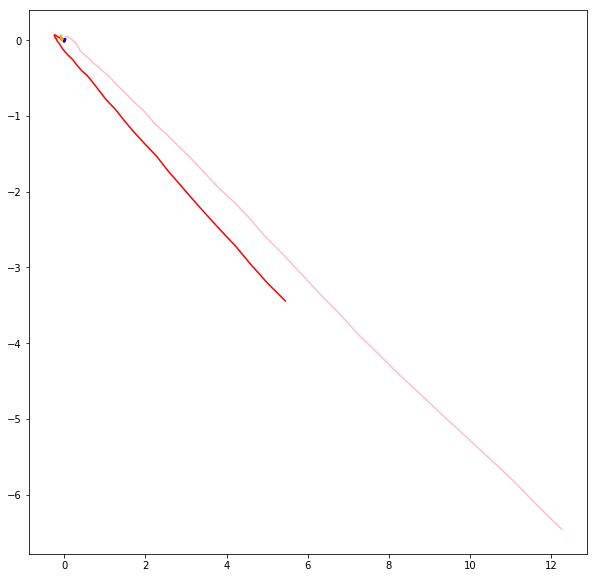

In [18]:
fig = plt.figure(figsize=(10,10))
pred_ = pred_coords[0].transpose(1,0)
plt.plot(pred_[0], pred_[1], color='red')
pred_ = pred_coords[1].transpose(1,0)
plt.plot(pred_[0], pred_[1], color='pink')
pred_ = pred_coords[2].transpose(1,0)
plt.plot(pred_[0], pred_[1], color='orange')
gt_coord_ = gt_coord.transpose(1,0)
plt.plot(gt_coord_[0], gt_coord_[1], color='blue')

In [19]:
count = 0

for key, ground_truth_value in ground_truth.items():
    gt_coord = ground_truth_value["coord"]
    avail = ground_truth_value["avail"]
    pred_coords = inference[key]["coords"]
    conf = inference[key]["conf"]
    if(np.max(gt_coord[:, 0])-np.min(gt_coord[:, 0])<=0.2):
        if(np.max(gt_coord[:, 1]) -np.min(gt_coord[:, 1])<=0.2):
            
            count += 1
count
            
#     print(conf)
#     print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
#     conf = np.array([1, 0, 0])
#     print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
#     conf = np.array([0, 1, 0])
#     print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))
#     conf = np.array([0, 0, 1])
#     print(neg_multi_log_likelihood(gt_coord, pred_coords, conf, avail))



25343

In [20]:
avail_ = np.ones(50)
# avail_ = avail

In [21]:
conf_ = np.array([1, 0, 0])

In [22]:
# gt_coord_ = np.ones(100).reshape(50, 2) / 5
gt_coord_ = gt_coord

In [23]:
pred_coords_ = np.zeros([3, 50, 2])
# pred_coords_ = out.values[5:].reshape([3, 50, 2])

In [24]:
neg_multi_log_likelihood(gt_coord_, pred_coords_, conf_, avail_)

38926.19807847765

In [25]:
timestamps = []
track_id = []
coords = []
for key, ground_truth_value in ground_truth.items():
    timestamps.append(ground_truth_value["timestamp"])
    track_id.append(ground_truth_value["track_id"])
    coords.append(np.array(ground_truth_value["coord"]).reshape(-1))

In [26]:
grands = np.hstack([np.array(timestamps).reshape(94694, 1), np.array(track_id).reshape(94694, 1), np.array(coords)])

In [27]:
grands = pd.DataFrame(grands)
grands[0] = grands[0].astype('int')
grands[1] = grands[1].astype('int')
grands.sort_values([0, 1], inplace=True)
grands.reset_index(inplace=True, drop=True)

grands.head(20)

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,101
0,1574364399902601396,1,0.33936,0.74268,0.70551,1.53467,1.08331,2.30396,1.44617,3.03198,...,13.99939,24.84814,14.16577,25.12769,14.29993,25.33227,14.48065,25.58081,14.59912,25.78589
1,1574364399902601396,3,0.41217,0.73145,0.73926,1.47388,1.19312,2.31079,1.57062,3.02734,...,14.36835,29.39649,14.43591,29.48804,14.75617,29.98047,14.81647,30.15405,14.92841,30.39551
2,1574364424902827486,2,0.7041,1.06958,1.39423,2.1604,2.11395,3.24146,2.84698,4.3186,...,31.93659,48.91235,32.66449,49.99536,33.34552,51.06836,34.07605,52.18433,34.78174,53.19434
3,1574364449901934626,836,-0.37897,-0.46472,-0.73987,-0.98987,-1.09082,-1.47876,-1.474,-2.02673,...,-21.45233,-31.79517,-21.87238,-32.43933,-22.29443,-33.10413,-22.97937,-34.17895,-23.53534,-35.03333
4,1574364474902117814,1,0.63397,0.99182,1.26569,2.00659,1.87195,3.05762,2.51581,4.06567,...,14.88104,48.82288,14.90655,49.84509,14.88788,50.95251,14.8476,51.96265,14.83209,53.04138
5,1574364515202921606,1,-0.67303,0.43787,-1.35413,0.85889,-2.02203,1.28528,-2.65137,1.68848,...,-27.64539,17.75562,-28.01971,18.01965,-28.48596,18.32141,-28.91467,18.57788,-29.33417,18.82642
6,1574364515202921606,4,-0.00122,-0.01929,-0.00867,-0.00293,0.0105,0.00525,0.01563,0.01868,...,-1.41486,0.87793,-1.35352,0.83545,-1.34033,0.8175,-1.50983,0.94299,-1.61908,1.02808
7,1574364515202921606,374,0.8548,-0.45923,1.7525,-0.94495,2.68579,-1.45532,3.63898,-1.98633,...,40.63172,-23.74732,41.43311,-24.24658,42.19183,-24.70483,42.93121,-25.15454,43.63147,-25.54126
8,1574364515202921606,405,0.58502,-0.35413,1.16345,-0.71301,1.76062,-1.0564,2.33685,-1.41968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1574364515202921606,431,0.51733,-0.33081,1.05048,-0.66565,1.61774,-1.01123,2.15399,-1.35022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
len(grands)

94694

In [51]:
output = pd.read_csv(str(OUTPUT_DIR)+'pred_1010.csv')
output.sort_values(['timestamp', 'track_id'], inplace=True)
output.reset_index(inplace=True, drop=True)
output.head(20)

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_x245,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249
0,1574364399902601396,1,0.452226,0.174998,0.372776,0.34957,0.76271,0.69857,1.51185,1.04778,...,14.03060,25.23630,14.24860,25.52203,14.46795,25.82146,14.69106,26.10049,14.88463,26.39717
1,1574364399902601396,3,0.423236,0.182002,0.394762,0.42872,0.83845,0.84257,1.71780,1.25206,...,14.58794,29.47554,14.83020,29.92471,15.07310,30.37962,15.30783,30.81406,15.52744,31.26325
2,1574364424902827486,2,0.419648,0.186097,0.394255,0.67392,1.07330,1.41239,2.23218,2.10737,...,31.94871,48.58669,32.62866,49.61435,33.29705,50.63986,33.97094,51.61868,34.61441,52.64727
3,1574364449901934626,836,0.506082,0.322601,0.171317,-0.33163,-0.44275,-0.70904,-0.90654,-1.02228,...,-13.88470,-15.38057,-14.16328,-15.59777,-14.38699,-15.83981,-14.66199,-15.99678,-14.90684,-16.25601
4,1574364474902117814,1,0.514791,0.206952,0.278257,0.55480,0.93011,1.14831,1.95220,1.71056,...,14.94818,45.91310,15.00540,46.99983,15.05335,48.06805,15.02526,49.05385,15.00696,50.06226
5,1574364515202921606,1,0.463332,0.228844,0.307824,-0.65831,0.41429,-1.35379,0.86611,-1.98587,...,-26.78478,17.15242,-27.30019,17.46882,-27.80577,17.77546,-28.28271,18.09477,-28.80830,18.40448
6,1574364515202921606,4,0.031332,0.009494,0.959174,-0.01217,0.00277,-0.02097,0.02937,-0.02142,...,0.24801,-0.11701,0.25297,-0.12515,0.25724,-0.13301,0.28166,-0.13909,0.28197,-0.15245
7,1574364515202921606,374,0.417288,0.163663,0.419049,0.94567,-0.55344,1.96440,-1.14092,2.91257,...,40.75915,-25.18089,41.54269,-25.67577,42.33239,-26.17027,43.09445,-26.67850,43.89818,-27.15229
8,1574364515202921606,405,0.436658,0.172193,0.391149,0.54888,-0.35429,1.13425,-0.70615,1.70331,...,24.20889,-15.65752,24.71117,-15.98573,25.20958,-16.31804,25.69224,-16.65084,26.18428,-16.98236
9,1574364515202921606,431,0.465800,0.208350,0.325850,0.49931,-0.34013,1.03991,-0.69332,1.54529,...,22.64704,-14.55873,23.14656,-14.85290,23.63019,-15.14481,24.10833,-15.44303,24.59602,-15.73624


In [52]:
for i in tqdm(range(len(grands))):
    if(output['timestamp'][i] != grands[0][i]):
        print(output['timestamp'][i])
    if(output['track_id'][i] != grands[1][i]):
        print(output['track_id'][i])

100%|██████████| 94694/94694 [00:02<00:00, 35561.63it/s]


In [53]:
output['timestamp'][0], grands[0][0]

(1574364399902601396, 1574364399902601396)

In [54]:
conf = output.loc[:, 'conf_0':'conf_2']
output1 = output.loc[:, 'coord_x00':'coord_y049']
output2 = output.loc[:, 'coord_x10':'coord_y149']
output3 = output.loc[:, 'coord_x20':'coord_y249']

In [55]:
outputs = [output1, output2, output3]

In [56]:
output_ = outputs[0].iloc[0].values
output_.shape
outputzero = np.zeros(outputs[0].iloc[0].values.shape)
confzero = np.array([1,0,0])

In [57]:
total_count = 0

for j in tqdm(range(len(output1))):
    count = 0
    for i in range(3):
        coord = outputs[i].iloc[j].values
        lenx = np.max(coord[::2])-np.min(coord[::2])
        leny = np.max(coord[1::2]) -np.min(coord[1::2])
        total_len = np.sqrt(lenx*lenx+leny*leny)
        if(total_len<=1.0):
            count += 1
            
    if(count==3):
        conf.iloc[j] = confzero
        output1.iloc[j] = outputzero
        total_count += 1
total_count
    
# for i, (key, ground_truth_value) in tqdm(enumerate(ground_truth.items())):


100%|██████████| 94694/94694 [00:38<00:00, 2469.46it/s]


194

In [35]:
count = 0
gt_coords = []
for i in tqdm(range(len(grands))):
# for i, (key, ground_truth_value) in tqdm(enumerate(ground_truth.items())):
    gt_coord = grands.iloc[i].values[2:].astype('float32')
    if(np.max(gt_coord[::2])-np.min(gt_coord[::2])<=1.0):
        if(np.max(gt_coord[1::2]) -np.min(gt_coord[1::2])<=1.0):
            count += 1
            output1.iloc[i] = outputzero
            conf.iloc[i] = confzero
            gt_coords.append(gt_coord)
count


100%|██████████| 94694/94694 [00:33<00:00, 2861.61it/s]


48309

In [58]:
output.loc[:, 'conf_0':'conf_2'] = conf
output.loc[:, 'coord_x00':'coord_y049'] = output1
output.loc[:, 'coord_x10':'coord_y149'] = output2
output.loc[:, 'coord_x20':'coord_y249'] = output3
output.head(10)

,timestamp,track_id,conf_0,conf_1,conf_2,coord_x00,coord_y00,coord_x01,coord_y01,coord_x02,...,coord_x245,coord_y245,coord_x246,coord_y246,coord_x247,coord_y247,coord_x248,coord_y248,coord_x249,coord_y249
0,1574364399902601396,1,0.452226,0.174998,0.372776,0.34957,0.76271,0.69857,1.51185,1.04778,...,14.03060,25.23630,14.24860,25.52203,14.46795,25.82146,14.69106,26.10049,14.88463,26.39717
1,1574364399902601396,3,0.423236,0.182002,0.394762,0.42872,0.83845,0.84257,1.71780,1.25206,...,14.58794,29.47554,14.83020,29.92471,15.07310,30.37962,15.30783,30.81406,15.52744,31.26325
2,1574364424902827486,2,0.419648,0.186097,0.394255,0.67392,1.07330,1.41239,2.23218,2.10737,...,31.94871,48.58669,32.62866,49.61435,33.29705,50.63986,33.97094,51.61868,34.61441,52.64727
3,1574364449901934626,836,0.506082,0.322601,0.171317,-0.33163,-0.44275,-0.70904,-0.90654,-1.02228,...,-13.88470,-15.38057,-14.16328,-15.59777,-14.38699,-15.83981,-14.66199,-15.99678,-14.90684,-16.25601
4,1574364474902117814,1,0.514791,0.206952,0.278257,0.55480,0.93011,1.14831,1.95220,1.71056,...,14.94818,45.91310,15.00540,46.99983,15.05335,48.06805,15.02526,49.05385,15.00696,50.06226
5,1574364515202921606,1,0.463332,0.228844,0.307824,-0.65831,0.41429,-1.35379,0.86611,-1.98587,...,-26.78478,17.15242,-27.30019,17.46882,-27.80577,17.77546,-28.28271,18.09477,-28.80830,18.40448
6,1574364515202921606,4,0.031332,0.009494,0.959174,-0.01217,0.00277,-0.02097,0.02937,-0.02142,...,0.24801,-0.11701,0.25297,-0.12515,0.25724,-0.13301,0.28166,-0.13909,0.28197,-0.15245
7,1574364515202921606,374,0.417288,0.163663,0.419049,0.94567,-0.55344,1.96440,-1.14092,2.91257,...,40.75915,-25.18089,41.54269,-25.67577,42.33239,-26.17027,43.09445,-26.67850,43.89818,-27.15229
8,1574364515202921606,405,0.436658,0.172193,0.391149,0.54888,-0.35429,1.13425,-0.70615,1.70331,...,24.20889,-15.65752,24.71117,-15.98573,25.20958,-16.31804,25.69224,-16.65084,26.18428,-16.98236
9,1574364515202921606,431,0.465800,0.208350,0.325850,0.49931,-0.34013,1.03991,-0.69332,1.54529,...,22.64704,-14.55873,23.14656,-14.85290,23.63019,-15.14481,24.10833,-15.44303,24.59602,-15.73624


In [61]:
# output.head(20)

In [126]:
# outs = []
# for i in tqdm(range(len(output))):
# # for i, (key, ground_truth_value) in tqdm(enumerate(ground_truth.items())):
#     out = output.iloc[i]
#     conf_0 = output['conf_0'][i]
#     if(conf_0 == 1):
#         outs.append(out)


In [62]:
output.to_csv(str(OUTPUT_DIR)+'pred_1010_custom.csv', index=False)

In [63]:
pred_path_ = str(OUTPUT_DIR)+'pred_1010_custom.csv'

In [64]:
metrics = compute_metrics_csv(eval_gt_path, pred_path_, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


neg_multi_log_likelihood 21.294072357081685
time_displace [0.05145862 0.0783774  0.09385911 0.11437382 0.13168549 0.14882467
 0.16639466 0.18505281 0.20453741 0.22123797 0.24019819 0.25797857
 0.27486181 0.29507052 0.30744419 0.32178611 0.33903384 0.35457169
 0.37038543 0.38330497 0.39536634 0.4063999  0.41300923 0.42278612
 0.43465691 0.44694134 0.45812054 0.46373244 0.47245717 0.4796033
 0.48929477 0.49763476 0.50740072 0.5113688  0.52263821 0.52958159
 0.5397799  0.55146587 0.56024063 0.5721148  0.58508793 0.59633528
 0.60919358 0.62235682 0.63707026 0.65157973 0.66892614 0.68588505
 0.70729636 0.72671867]


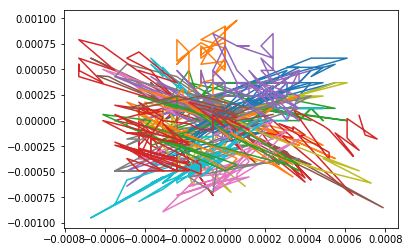

In [123]:
for i in range(len(gt_coords)):
    gt_coord = gt_coords[i]
    plt.plot(gt_coord[::2], gt_coord[1::2])

In [120]:
gt_coord.shape

(99,)